### First attempt sticking grizli output into PostgreSQL tables

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display, HTML

import pandas as pd
pd.set_option('display.max_colwidth', -1)

from grizli import utils, __version__
from grizli.aws import db as grizli_db

try:
    from mastquery import overlaps
except:
    overlaps = None
    
print('Grizli version: ', __version__)
utils.set_warnings()

Grizli version:  1.0-22-g93c27d5


### postgresql tables on AWS RDS

I've started dumping information into `postgresql` tables and the potential seems awesome, even for my hacky database layout.  

**How does one set this up on TAP / ADQL??**

In [3]:
# readonly DB access
config = {'hostname': 'grizdbinstance.c3prl6czsxrm.us-east-1.rds.amazonaws.com',
 'username': 'redshift_fit_public',
 'password': '** EMAIL G.BRAMMER FOR PASSWORD **',
 'database': 'grizlifields',
 'port': 5432}

# sqlalchemy engine for postgresql
engine = grizli_db.get_db_engine(config=config)
print('Tables: ', engine.table_names())

/Users/gbrammer/miniconda3/envs/grizli-dev/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Tables:  ['redshift_fit', 'charge_fields', 'z_spec_tmp', 'xmm_dr8', 'survey_fields', 'observation', 'field_observation', 'photometry_apcorr', 'photometry_detect']


### Redshift fit status flags from the fits run on Lambda

`redshift_fit.status`:

  **`3`** - The object should have an extracted `beams.fits` file in the S3 filesystem

  **`5`** - extractions and redshift fits that timed out in the 15 minute Lambda limit, 
            e.g., some deep pointings or unconstrained fits that find many peaks on the second pass

  **`6`** : completed redshift fits with full information stored in the `redshift_fit` table.


In [4]:
print(grizli_db.FLAGS)

{'init_lambda': 1, 'start_beams': 2, 'done_beams': 3, 'no_run_fit': 4, 'start_redshift_fit': 5, 'fit_complete': 6}


In [5]:
for table in ['charge_fields', 'photometry_apcorr', 'redshift_fit']:
    photom = pd.read_sql_query('select * from {0} where false;'.format(table), engine)
    cols = list(photom.columns)
    count = pd.read_sql_query('select count(*) as n from {0};'.format(table), engine)
    
    print('###  Table `{0}`: {1} rows x {2} columns   ###\n' .format(table, 
                                                    count['n'][0], len(photom.columns)))
    
    r, c = 6, 10
    for i in range(c):
        print('   '+', '.join(['{0:10}'.format(ci) for ci in cols[i*r:(i+1)*r]]))
    print('    ...\n')      

###  Table `charge_fields`: 2502 rows x 377 columns   ###

   qtime     , boxra     , boxdec    , boxrad    , obsquery  , field_root
   field_ra  , field_dec , mw_ebv    , folap     , min_area  , buffer    
   field_xmin, field_xmax, field_ymin, field_ymax, boxquery  , nassoc    
   ecllat    , ecllon    , gallat    , gallon    , nfilt     , filter    
   target    , target_classification, proposal_id, proposal_pi, ng102     , areag102  
   texpg102  , tperg102  , pag102    , ng141     , areag141  , texpg141  
   tperg141  , pag141    , ng800l    , areag800l , texpg800l , tperg800l 
   pag800l   , ng280     , areag280  , texpg280  , tperg280  , pag280    
   mast      , footprint , skip      , has_wfc3ir, comment   , gaia5     
   t_acs_wfc_clear1l_f814w, wh_acs_wfc_clear1l_f814w, a_acs_wfc_clear1l_f814w, t_acs_wfc_f435w, wh_acs_wfc_f435w, a_acs_wfc_f435w
    ...

###  Table `photometry_apcorr`: 1910827 rows x 1300 columns   ###

   thresh    , npix      , tnpix     , image_xmin, image

## Example query: z_grism vs z_spec

Here z_specs are taken from a large variety of literature sources.
I've taken separate tables and matched them into the `photometry_apcorr` database, but 
this would better be done with a separate z_spec table in the database.

The `make_html_table` function below automatically does a join on `redshift_fit` and `photometry_apcorr` based on the object `root` + `id` combinations.

If you don't set `get_sql=True`, it makes a sortable HTML table like the link below sends it to the S3 target specified in `sync`.

### Full table: https://s3.amazonaws.com/grizli-v1/tables/zspec_delta.html?&status_min=5.5


In [6]:
SQLtxt = grizli_db.make_html_table(engine=engine, 
                   columns=['root','status','id','ra','dec','mag_auto','flux_radius',
                            'z_spec','z_map','z_spec_src','bic_diff','chinu','log_pdf_max', 
                            'zwidth1/(1+z_map) as zw1','(z_map-z_spec)/(1+z_spec) as dz'], 
                   where="AND status > 4 AND z_spec > 0 AND z_spec_qual = 1 AND z_spec_src NOT LIKE '%%Caminha%%'", 
                   table_root='zspec_delta', sync='s3://grizli-v1/tables/', 
                   png_ext=['R30', 'stack','full','line'], get_sql=True)

print(SQLtxt.replace('FROM','\n    FROM').replace('WHERE','\n    WHERE'))

# Below is like `pd.read_sql_query` but sends result 
# to an astropy table rather than a `DataFrame`
res = grizli_db.from_sql(SQLtxt, engine)

SELECT root,status,id,ra,dec,mag_auto,flux_radius,z_spec,z_map,z_spec_src,bic_diff,chinu,log_pdf_max,zwidth1/(1+z_map) as zw1,(z_map-z_spec)/(1+z_spec) as dz 
    FROM photometry_apcorr, redshift_fit 
    WHERE root = p_root AND id = p_id AND status > 4 AND z_spec > 0 AND z_spec_qual = 1 AND z_spec_src NOT LIKE '%%Caminha%%';


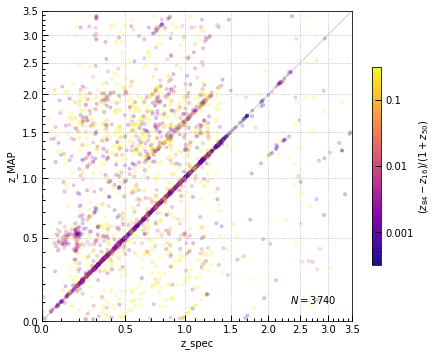

In [7]:
# z_grism vs z_spec
from matplotlib.ticker import FixedLocator, AutoLocator, MaxNLocator

# Pseudolog in log(1+z)
xti = xt = np.arange(0,3.6,0.5)
loc = np.arange(0, 3.6, 0.1)

fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111)

kwargs = {'marker':'.', 'vmin':-3.5, 'vmax': -0.5, 'cmap': 'plasma'}

ax.scatter(np.log(1+res['z_spec']), np.log(1+res['z_map']), alpha=0.2, 
           c=np.log10(res['zw1']), **kwargs)

# dummy replot for darker colorbar
sc = ax.scatter(np.log([1]), np.log([1]), alpha=0.8, c=[0], **kwargs)
cb = plt.colorbar(sc, shrink=0.6)
cb.set_label(r'$(z_{84}-z_{16})/(1+z_{50})$')
cb.set_ticks([-3,-2,-1])
cb.set_ticklabels([0.001, 0.01, 0.1])

xts = ax.set_xticks(np.log(1+xt))
xtl = ax.set_xticklabels(xti)
xts = ax.set_yticks(np.log(1+xt))
xtl = ax.set_yticklabels(xti)

ax.set_xlim(0, np.log(1+3.5))
ax.set_ylim(0, np.log(1+3.5))

ax.xaxis.set_minor_locator(FixedLocator(np.log(1+loc)))                                                                                                                                          
ax.yaxis.set_minor_locator(FixedLocator(np.log(1+loc)))      

ax.set_xlabel('z_spec')
ax.set_ylabel('z_MAP')

ax.set_aspect(1)
ax.grid()
ax.text(0.95, 0.05, r'$N={0}$'.format(len(res)), ha='right', va='bottom', 
        transform=ax.transAxes)

ax.plot(ax.get_xlim(), ax.get_xlim(), color='k', 
        alpha=0.2, linewidth=1, zorder=-10)

fig.tight_layout(pad=0.1)

In [8]:
# z_spec references
SQL = """
SELECT * FROM (SELECT z_spec_src, count(z_spec_src) AS n FROM photometry_apcorr 
    WHERE z_spec_qual = 1 AND z_spec_src NOT LIKE '%%Caminha%%' GROUP BY z_spec_src) foo ORDER BY n DESC;
"""
counts = grizli_db.from_sql(SQL, engine)

In [9]:
counts[0:20]

z_spec_src,n
str30,int64
deep2-dr4,2276
Damjanov 2018,713
sdss-dr15-GALAXY,653
sparcs,645
Owers 2011a,340
vipers-dr2-w1,317
sdss-dr15-QSO,260
AGES Kochanek,239
Ruel 2014,225


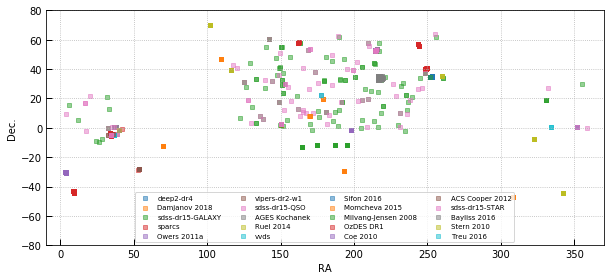

In [10]:
# Show where the sources are on the sky
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(111)

for src in counts['z_spec_src'][0:20]:
    sub = res['z_spec_src'] == src
    ax.scatter(res['ra'][sub], res['dec'][sub], marker='s', s=20, 
               label=src, alpha=0.5)

ax.set_aspect(1)
ax.set_xlim(-10, 370); ax.set_ylim(-80, 80)
ax.set_xlabel('RA'); ax.set_ylabel('Dec.')
ax.grid()
ax.legend(loc='lower center', fontsize=7, ncol=4)

In [11]:
# Individual object: high-z quasar
SQLtxt = grizli_db.make_html_table(engine=engine, 
                                columns=['status','root','id','ra','dec','mag_auto','flux_radius',
                                         'z_spec','z_map','z_spec_src'], 
                                where="AND status > 4 AND z_spec > 6.0 AND z_spec_qual = 1",  get_sql=True)

print(SQLtxt.replace('FROM','\n    FROM').replace('WHERE','\n    WHERE'))

# `from_sql` is like `pd.read_sql_query` but sends result 
# to an astropy table rather than a `DataFrame`
highz = grizli_db.from_sql(SQLtxt, engine)

SELECT status,root,id,ra,dec,mag_auto,flux_radius,z_spec,z_map,z_spec_src 
    FROM photometry_apcorr, redshift_fit 
    WHERE root = p_root AND id = p_id AND status > 4 AND z_spec > 6.0 AND z_spec_qual = 1;


In [12]:
highz

status,root,id,ra,dec,mag_auto,flux_radius,z_spec,z_map,z_spec_src
int64,str12,int64,float64,float64,float64,float64,float64,float64,str20
6,j142952p5447,719,217.46700,54.78820,20.55,1.2,6.210,6.172,Wang 2016 high-z QSO


In [13]:
HTML(grizli_db.render_for_notebook(highz['root','id','ra','dec','mag_auto','z_spec','z_map'], 
                                   image_extensions=['stack','full']))

,root,id,ra,dec,mag_auto,z_spec,z_map,stack,full
0,j142952p5447,719,217.467,54.7882,20.549747,6.21,6.17207,,


In [14]:
# SDSS quasars
qso = (res['z_spec_src'] == 'sdss-dr15-QSO')
print('{0} SDSS QSOs'.format(qso.sum()))
arc = (res['z_spec_src'] == 'Rigby 2018')
print('{0} Megasaura arc images'.format(arc.sum()))

71 SDSS QSOs
4 Megasaura arc images


In [15]:
HTML(grizli_db.render_for_notebook(res[arc]['root','id','ra','dec','mag_auto','z_spec','z_map'], 
                                   image_extensions=['stack','full','line']))

,root,id,ra,dec,mag_auto,z_spec,z_map,stack,full,line
0,j032728m1326,1476,51.8665,-13.4359,20.665002,1.703400,1.70635,,,
1,j032728m1326,1475,51.8675,-13.4368,20.096246,1.703884,1.70493,,,
2,j032728m1326,1477,51.8657,-13.4355,20.994835,1.703600,1.70429,,,
3,j032728m1326,815,51.8632,-13.4484,21.165216,1.703070,1.70306,,,


### 3D-HST

Spectra in EGS, COSMOS, and UDS have been processed but those fields don't have a full `z_spec` catalog yet.  The field names are a bit different than the `jHHMMSSxDDMMSS` format for the other archival fields.

In [16]:
SQLtxt = """
SELECT status,root,id,p_ra as ra,p_dec as dec,mag_auto,flux_radius,
       t_g800l,t_g141,t_g102,z_spec,z_map,z_spec_src,z_spec_qual,
       bic_diff,zwidth1/(1+z_map) as zw1,
       zwidth2/(1+z_map) as zw2,
       z02,z16,z50,z84,z97
    FROM photometry_apcorr, redshift_fit
WHERE root = p_root AND id = p_id AND status > 4
AND root LIKE '%%grism%%';
"""

print(SQLtxt)
tab = grizli_db.from_sql(SQLtxt, engine)
print('N total: {0} \nN fields: {1}'.format(len(tab), len(np.unique(tab['root']))))


SELECT status,root,id,p_ra as ra,p_dec as dec,mag_auto,flux_radius,
       t_g800l,t_g141,t_g102,z_spec,z_map,z_spec_src,z_spec_qual,
       bic_diff,zwidth1/(1+z_map) as zw1,
       zwidth2/(1+z_map) as zw2,
       z02,z16,z50,z84,z97
    FROM photometry_apcorr, redshift_fit
WHERE root = p_root AND id = p_id AND status > 4
AND root LIKE '%%grism%%';

N total: 55766 
N fields: 3


cos-grism-j100012p0210 17123 10340 18215
egs-grism-j141956p5255 22775 13590 12252
uds-grism-j021732m0512 15868 8813 8563


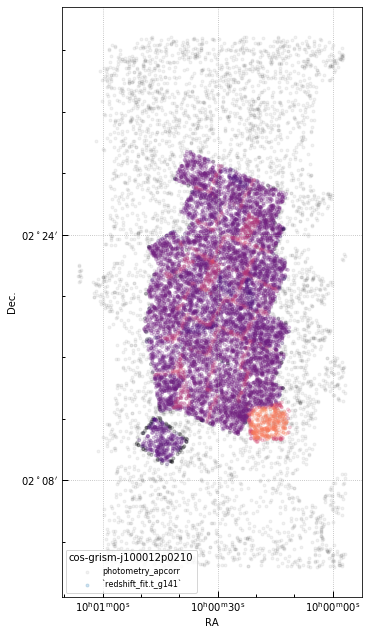

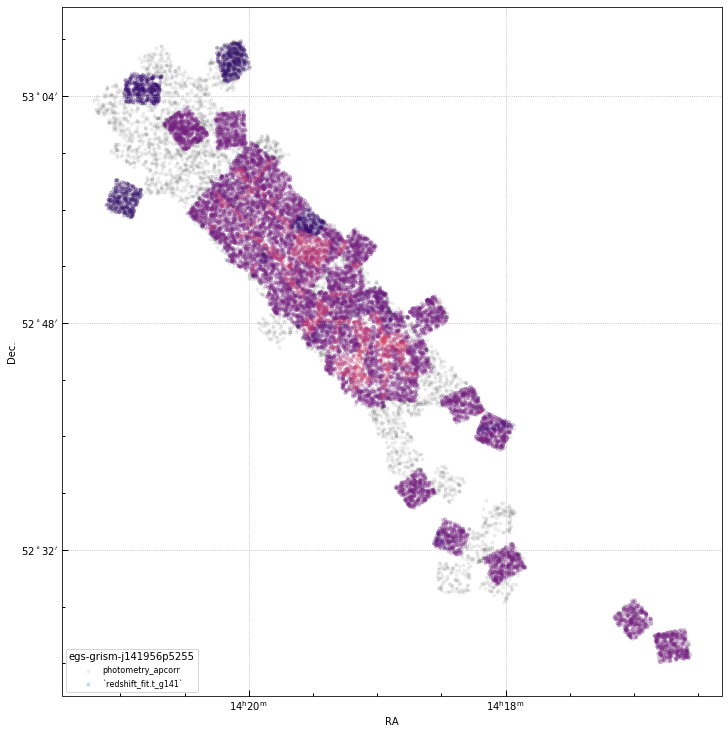

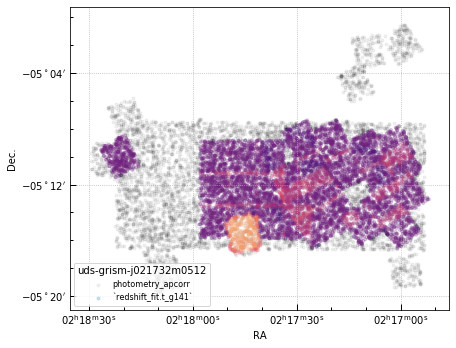

In [17]:
SQLphot = """
SELECT p_root as root, p_ra as ra, p_dec as dec, mag_auto 
       FROM photometry_apcorr
WHERE p_root LIKE '{0}' AND mag_auto < 24 ORDER BY mag_auto;
"""

# Show the field layouts
fields = np.unique(tab['root'])
msel = tab['mag_auto'] < 25

c = (tab['status'],4.5,6.2)
c = (np.log10(tab['t_g141']),3,5)

for field in fields:
    fsel = (tab['root'] == field)
    f_i = tab[fsel & msel]
    so = np.argsort(tab['status'][fsel & msel])
    f_i = f_i[so]
    
    # All sources from parent photometry database
    ex = grizli_db.from_sql(SQLphot.format(field), engine)
    sk = len(ex)//5000 # skip
    sk = 1 if sk == 0 else sk
    
    print(field, fsel.sum(), (fsel & msel).sum(), len(ex))
    
    dy = (ex['dec'].max()-ex['dec'].min())*60
    dx = (ex['ra'].max()-ex['ra'].min())*60*np.cos(ex['dec'][0]/180*np.pi)
    s = np.clip(5*(np.maximum(dx, dy)/20), 5, 10)

    fig = plt.figure(figsize=[s,s])
    ax = fig.add_subplot(111)
    
    ax.scatter(ex['ra'][::sk], ex['dec'][::sk], marker='.', color='k', 
               alpha=0.05, zorder=-1, label='photometry_apcorr')

    ax.scatter(f_i['ra'], f_i['dec'], c=c[0][fsel & msel][so], alpha=0.2, 
               marker='.', vmin=c[1], vmax=c[2], cmap='magma', 
               label='`redshift_fit.{0}`'.format(c[0].name))
    
    ax.set_aspect(1./np.cos(f_i['dec'][0]/180*np.pi))
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_xlabel('RA'); ax.set_ylabel('Dec.')
    fig.tight_layout(pad=0.2)

    if overlaps is not None:
        overlaps.draw_axis_labels(ax=ax, nlabel=3, format='latex')

    leg = ax.legend(title=field, loc='lower left', fontsize=8)
    
#     ax.text(0.03, 0.03, field, ha='left', va='bottom', 
#             transform=ax.transAxes, fontsize=9, 
#             bbox={'facecolor':'w', 'alpha':0.5, 'edgecolor':'None'})
    
    ax.grid()

### Objects near quasars

Look at some quasar fields selected to be rich absorbers but that also often have excess sources around the quasar itself.

In [18]:
# Get field information from the charge database
pi_names = ['Bielby']

pi_query = 'OR '.join(["proposal_pi LIKE '%%{0}%%'".format(pi) for pi in pi_names])
SQLtxt = """
SELECT status,root,id,p_ra as ra,p_dec as dec,mag_auto,flux_radius,
       t_g800l,t_g141,t_g102,z_spec,z_map,z_spec_src,z_spec_qual,
       bic_diff,zwidth1/(1+z_map) as zw1,
       zwidth2/(1+z_map) as zw2,
       z02,z16,z50,z84,z97,
       comment,proposal_pi,target
    FROM photometry_apcorr, redshift_fit, charge_fields
WHERE root = p_root AND id = p_id AND field_root = p_root AND status > 4
AND ({0});
""".format(pi_query)
print(SQLtxt)

tab = grizli_db.from_sql(SQLtxt, engine)
print('N total: {0} \nN fields: {1}'.format(len(tab), len(np.unique(tab['root']))))


SELECT status,root,id,p_ra as ra,p_dec as dec,mag_auto,flux_radius,
       t_g800l,t_g141,t_g102,z_spec,z_map,z_spec_src,z_spec_qual,
       bic_diff,zwidth1/(1+z_map) as zw1,
       zwidth2/(1+z_map) as zw2,
       z02,z16,z50,z84,z97,
       comment,proposal_pi,target
    FROM photometry_apcorr, redshift_fit, charge_fields
WHERE root = p_root AND id = p_id AND field_root = p_root AND status > 4
AND (proposal_pi LIKE '%%Bielby%%');

N total: 6325 
N fields: 12


In [19]:
# Show histograms
SHOW_HISTOGRAM = True
# Select histogram on grism redshifts, otherwise try to use z_spec
GRISM_HISTOGRAM = False

j012016p2134 Ntot=561 Nmag=462 Nphot=321 n(z_spec)=2
j023508m0402 Ntot=566 Nmag=408 Nphot=361 n(z_spec)=5
j051708m4411 Ntot=509 Nmag=415 Nphot=272 n(z_map)=358
j075056p4252 Ntot=422 Nmag=350 Nphot=226 n(z_spec)=2
j081332p2545 Ntot=526 Nmag=457 Nphot=328 n(z_spec)=1
j101956p2744 Ntot=449 Nmag=376 Nphot=243 n(z_spec)=1
j112444m1705 Ntot=487 Nmag=422 Nphot=305 n(z_map)=65
j113008m1449 Ntot=473 Nmag=415 Nphot=276 n(z_spec)=1
j143748m0147 Ntot=623 Nmag=497 Nphot=447 n(z_spec)=2
j152424p0958 Ntot=597 Nmag=447 Nphot=412 n(z_spec)=1
j163200p3738 Ntot=552 Nmag=441 Nphot=447 n(z_spec)=2
j163432p7032 Ntot=560 Nmag=394 Nphot=382 n(z_map)=387


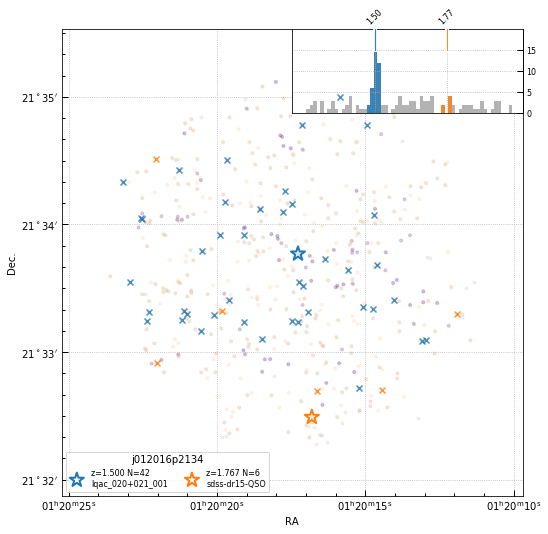

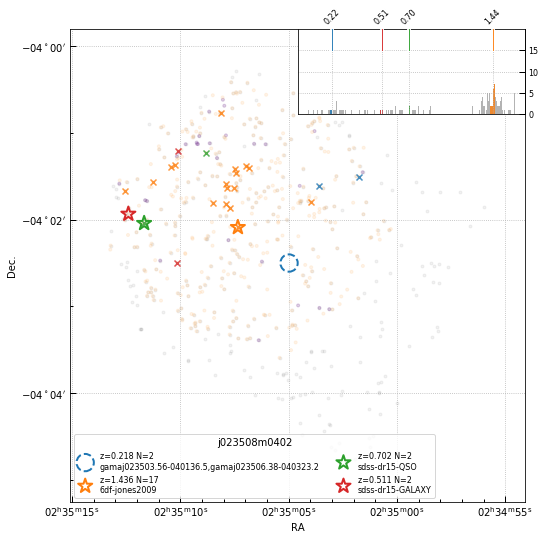

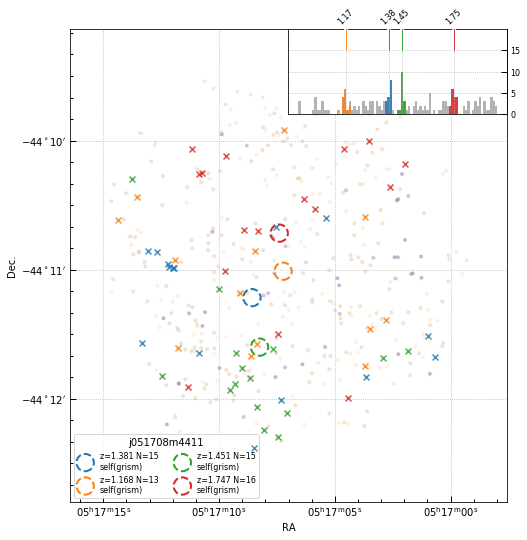

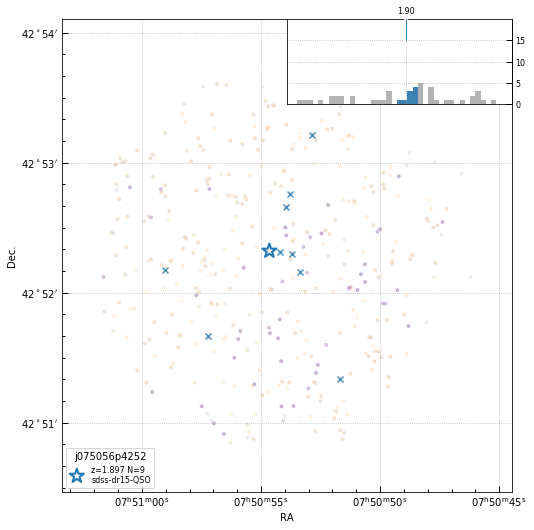

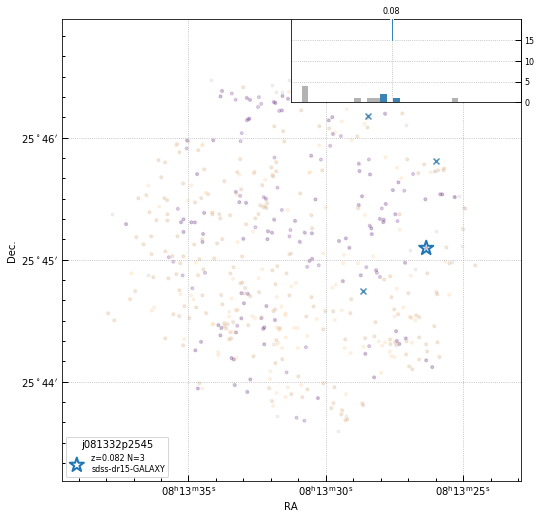

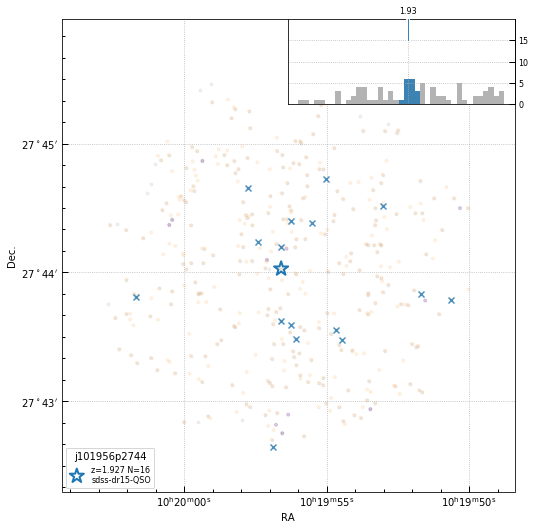

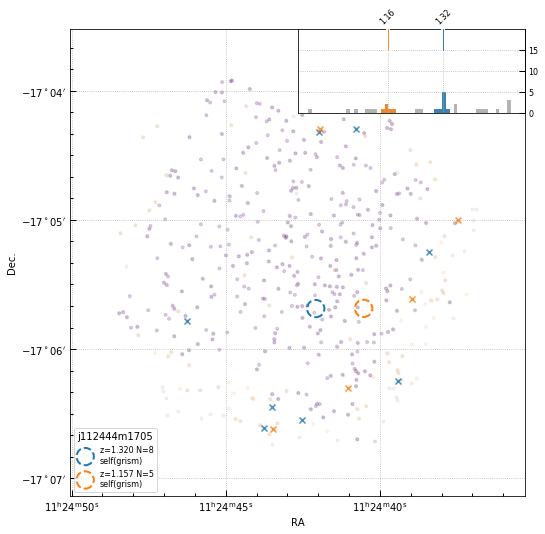

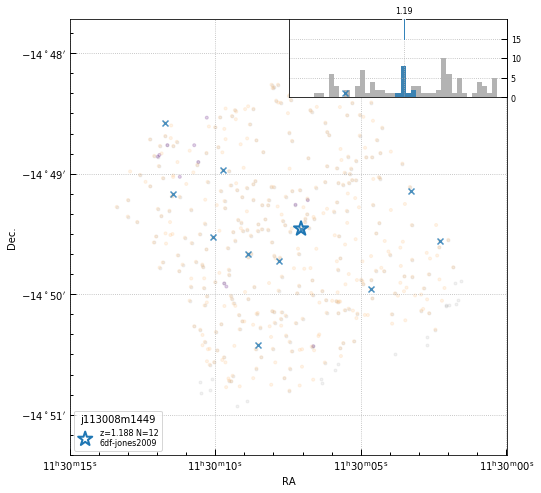

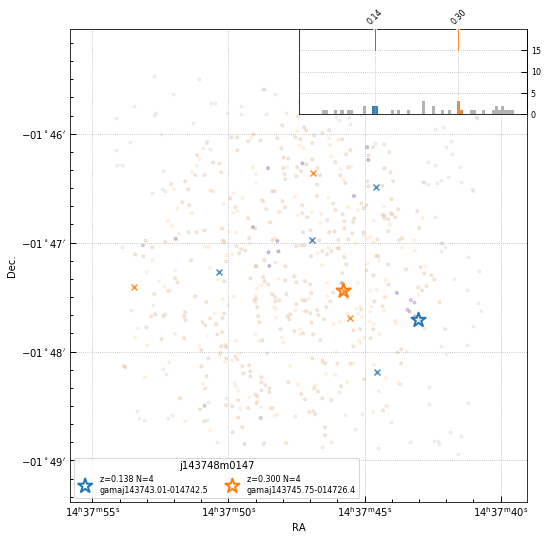

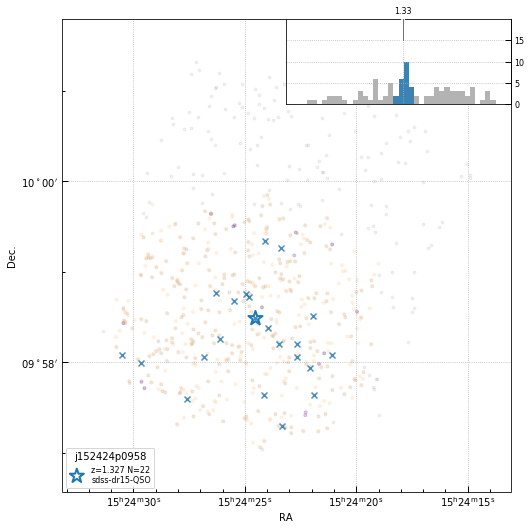

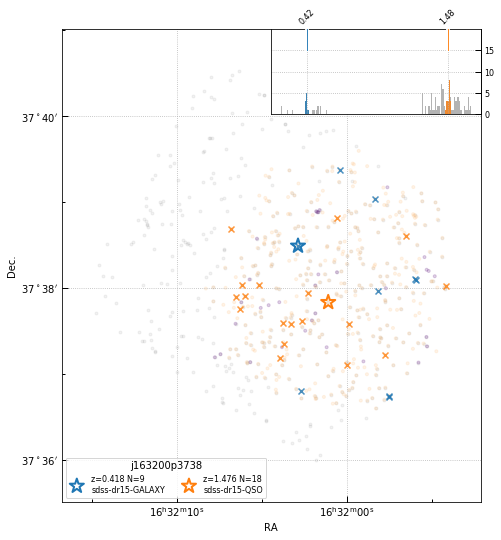

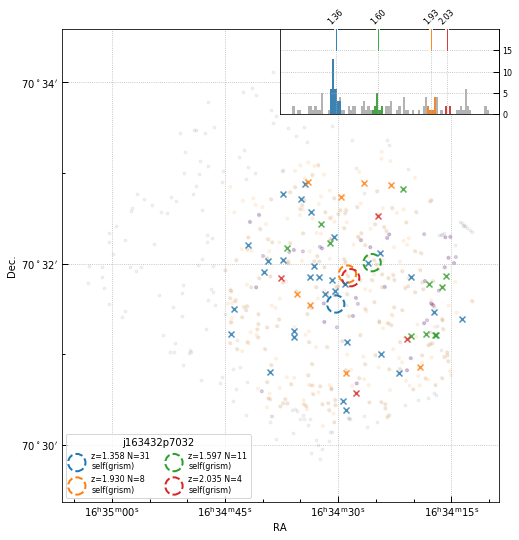

In [20]:
########## Make field layout plots with optional histograms
SQLphot = """
SELECT p_root as root, p_ra as ra, p_dec as dec, mag_auto 
       FROM photometry_apcorr
WHERE p_root LIKE '{0}' AND mag_auto < 24 ORDER BY mag_auto;
"""

fields = np.unique(tab['root'])
msel = tab['mag_auto'] < 25
#qso = tab['z_spec_src'].filled('---') == 'sdss-dr15-QSO'
qso = (tab['z_spec_qual'].filled(0) == 1) #== 'sdss-dr15-QSO'
qso &= ~utils.column_string_operation(tab['z_spec_src'].filled('---'), 'erb', 'startswith')

# Color by status
c = (tab['status'], 4.5, 6.2)
# Color by grism exposure time
#c = (np.log10(tab['t_g800l'].filled(1) + tab['t_g141'].filled(1) + tab['t_g102'].filled(1)), 3, 5)

# bins for histograms
bins = utils.log_zgrid([0.01, 3.5], 0.005)

# Coarse binning for maxima
spbins = utils.log_zgrid([0.01, 3.5], 0.03)

URL = 'https://s3.amazonaws.com/grizli-v1/Pipeline/{0}/Extractions/{0}.html?&z_map_min={1:.04f}&z_map_max={2:.04f}'
URL += '&bic_diff_min=10&chinu_max=2'

links = []
for field in fields:
    fsel = (tab['root'].filled() == field)
    fq = fsel & qso

    f_i = tab[fsel & msel]
    so = np.argsort(tab['status'][fsel & msel])
    f_i = f_i[so]

    # All sources from parent photometry database
    ex = grizli_db.from_sql(SQLphot.format(field), engine)
    sk = len(ex)//5000 # skip
    sk = 1 if sk == 0 else sk
    
    # Figure size
    dy = (ex['dec'].max()-ex['dec'].min())*60
    dx = (ex['ra'].max()-ex['ra'].min())*60*np.cos(ex['dec'][0]/180*np.pi)
    s = np.clip(8*(np.maximum(dx, dy)/20), 7, 14)
    fig = plt.figure(figsize=[s,s])
    
    ax = fig.add_subplot(111)
    
    # All sources
    ax.scatter(ex['ra'][::sk], ex['dec'][::sk], marker='.', color='k', 
           alpha=0.05, zorder=-1, label=None)
    
    # grism sources
    ax.scatter(f_i['ra'], f_i['dec'], c=c[0][fsel & msel][so], alpha=0.2, 
               marker='.', vmin=c[1], vmax=c[2], cmap='magma', label=None)
    
    ax.set_aspect(1./np.cos(f_i['dec'][0]/180*np.pi))
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_xlabel('RA'); ax.set_ylabel('Dec.')
    fig.tight_layout(pad=0.2)

    #overlaps.draw_axis_labels(ax=ax, nlabel=3, format='latex')
    
    # Quality redshifts
    qual = (f_i['bic_diff'] > 10) | (f_i['zw1'] < 0.02)
    
    max_npeak = 3

    # Histograms
    if (fq.sum() == 0) | (GRISM_HISTOGRAM):
        fq = fsel & ((tab['bic_diff'] > 10) | (tab['zw1'] < 0.02))
        nmin = 6
        zcol = 'z_map'

    else:
        nmin = 1
        zcol = 'z_spec'
    
    print('{0} Ntot={1} Nmag={2} Nphot={3} n({4})={5}'.format(field, fsel.sum(), (fsel & msel).sum(),
                                                              len(ex), zcol, fq.sum()))
    
    if (fq.sum() > 0) & (SHOW_HISTOGRAM):
        
        d1, d2 = 0.5, 0.18
        ax2 = ax.inset_axes((1-d1, 1-d2, d1, d2))
        xt = []
        
        yh, xh = np.histogram(tab[fq][zcol], bins=spbins)
        bso = np.argsort(yh)[::-1]

        for i, ib in enumerate(bso):
            if (yh[ib] < nmin) | (i > max_npeak):
                break
            
            ii = (tab[fq][zcol] >= xh[ib]) & (tab[fq][zcol] < xh[ib+1])
            zsp = tab[fq][zcol][ii].mean()
            
            if zcol == 'z_spec':
                zsrc = '\n'+','.join(list(np.unique(tab[fq]['z_spec_src'][ii])))
            else:
                zsrc = '\nself(grism)'
                
            plw = ax2.plot([np.log(1+zsp)]*2, [15, 20], color='w', linewidth=4, alpha=0.9, zorder=8)
            pl = ax2.plot([np.log(1+zsp)]*2, [15, 20], linewidth=1, alpha=0.9, zorder=10)
            color_i = pl[0].get_color()

            b_i = np.abs((bins-zsp)/(1+zsp)) < 0.1
            ax2.hist(np.log(1+f_i['z_map'][qual]), bins=np.log(1+bins[b_i]), color='0.7', zorder=-5)
            xt.append(zsp)
            
            # Plot positions and histogram of objects near the z_spec (QSO) objects
            near = qual & (np.abs((f_i['z_map']-zsp)/(1+zsp)) < 0.01)
            
            ax2.hist(np.log(1+f_i['z_map'][near]), bins=np.log(1+bins[b_i]), color=color_i, alpha=0.8)
            
            label = 'z={0:.3f} N={1}{2}'.format(zsp, near.sum(), zsrc)
            
            dzi = 0.01*(1+zsp)
            URLi = URL.format(field, zsp-dzi, zsp+dzi)
            links.append(HTML('<a href={0}>{1} / {2}</a>'.format(URLi, field, label)))
            
            if (zcol == 'z_spec') & (ii.sum() == 1):
                ax.scatter(tab[fq]['ra'][ii][:2], tab[fq]['dec'][ii][:2], 
                       edgecolor=color_i, facecolor='None', alpha=1, 
                       s=220, marker='*', zorder=100, linewidth=2,
                       label=label)
            else:
                ax.scatter(tab[fq]['ra'][ii].mean(), tab[fq]['dec'][ii].mean(), 
                       edgecolor=color_i, facecolor='None', alpha=1, 
                       s=300, marker='o', zorder=100, linewidth=2, linestyle='--',
                       label=label)
                
            ax.scatter(f_i['ra'][near], f_i['dec'][near], marker='x', 
                       color=color_i, alpha=0.8, zorder=1000,
                       label=None)
            
        ax2.set_xticks(np.log(1+np.array(xt))); 
        ax2.set_xticklabels(['{0:.2f}'.format(xti) for xti in xt], rotation=45*(len(xt) > 1))
        ax2.set_ylim(0,20); ax2.set_yticks([0,5,10,15])
        ax2.grid()
        ax2.tick_params(labelsize=8)
        
        ax2.xaxis.set_ticks_position('top')
        ax2.yaxis.set_ticks_position('right')

        ax.legend(loc='lower left', fontsize=8, title=field, ncol=1+(ib > 2)*1)
    else:
        ax.text(0.03, 0.03, field, ha='left', va='bottom', 
            transform=ax.transAxes, fontsize=9, 
            bbox={'facecolor':'w', 'alpha':0.5, 'edgecolor':'None'})

    if overlaps is not None:
        overlaps.draw_axis_labels(ax=ax, nlabel=3, format='latex')

    ax.grid()

# Show URLS
display(*links)